# 00_Initial-Cell-Filtering

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import numpy as np
import scanpy as sc
import pysam

In [20]:
colon_dna_fn = '/broad/thechenlab/pipeline_slidetag/data/240609_SL-EXC_0308_A22KHFYLT3/count'
colon_rna_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger'
colon_spatial_fn = '/broad/thechenlab/Andy/slide_tag_dna/colon_droplet/data/Mehdi_smaht_153_celltypes_locations.csv'
# bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger/xBO153_GEX_240625/outs/possorted_genome_bam.bam' # RNA
bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam' 
maf_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.txt'

In [4]:
colon_spatial_df = pd.read_csv(colon_spatial_fn, sep=',', index_col=0)

In [5]:
colon_spatial_df.head()

,cell_type,x,y,cell_type_broad
AAACCGAAGGCAATAG-1,Intermediate Epithelial,NaN,NaN,Epithelial
AAACCGAAGTATCGCG-1,Progenitor Epithelial,4639.436632,3248.049118,Epithelial
AAACCGGCATCTTGAG-1,T cell,NaN,NaN,Immune
AAACGCGCATGGAGGC-1,Fibroblast_1,2043.568952,1025.101805,Stromal
AAACGGATCATGCTTT-1,Goblet,4539.478596,3205.408255,Epithelial


In [6]:
maf_df = pd.read_csv(maf_fn, sep='\t')
maf_df.head()

,Chr,Pos,Ref,Alt,NV,NR,VAF
0,chr1,16856,A,G,5,44,0.113636
1,chr1,108540,A,C,7,44,0.159091
2,chr1,127491,T,G,16,70,0.228571
3,chr1,268043,C,T,11,78,0.141026
4,chr1,275337,T,C,6,55,0.109091


1. Mutation calls with Mutect2 from Tim. Want to deconvolve the mutation calling to each of the individual cells
1. Once mutations have been called between cells, can link them to the spatial locations. Perform moran's I or other spatial permutation tests
    1. we expect germline to be high VAF (in bulk) and everywhere
    1. somatic mutations to be low VAF (in bulk) and in specific locations?
    1. artifacts might be doing something else

In [ ]:
def get_mutation_relative_positions(bam_file, maf_file):
    """
    Identify the relative positions of a mutation on supporting reads.

    Parameters:
    - bam_file: Path to the BAM file
    - chrom: Chromosome of the mutation
    - pos: 1-based genomic position of the mutation
    - ref_base: Reference base at the mutation position
    - alt_base: Alternate base (mutation) at the position

    Returns:
    - A list of relative positions (mutation position / read length)
    """
    
    maf_df = pd.read_csv(maf_file, sep='\t')
    
    # Open BAM file
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        
        for i, r in maf_df.iterrows():
            chrom = r['Chr']
            pos = r['Pos']
            ref_base = r['Ref']
            alt_base = r['Alt']
            
            alt_relative_positions = []
            
            for read in bam.fetch(chrom, pos - 1, pos):  # Fetch reads overlapping mutation site
                if read.is_unmapped or read.is_secondary or read.is_supplementary:
                    continue  # Skip unmapped/secondary/supplementary alignments

                aligned_pairs = read.get_aligned_pairs(matches_only=True)  # List of (read_pos, ref_pos)
                read_length = read.query_length

                for read_pos, ref_pos in aligned_pairs:
                    if ref_pos == pos - 1:  # 0-based in pysam
                        read_base = read.query_sequence[read_pos]

                        if read_base == alt_base:  # Mutation is present in read
                            alt_relative_positions.append(read_pos / read_length)  # Normalize to read length
                        break  # No need to check further in this read

    return relative_positions

In [22]:
maf_df.head()

,Chr,Pos,Ref,Alt,NV,NR,VAF,nsegments
0,chr1,16856,A,G,5,44,0.113636,7.0
1,chr1,108540,A,C,7,44,0.159091,6.0
2,chr1,127491,T,G,16,70,0.228571,10.0
3,chr1,268043,C,T,11,78,0.141026,6.0
4,chr1,275337,T,C,6,55,0.109091,6.0


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

For each mutation:
- record distribution of the relative location of the mutation on the read (don't need to differentiation between alt and ref)
- for all the reads piled up on this region, where is the relative location of the genomic position on these reads


In [84]:
with pysam.AlignmentFile(bam_fn, "rb") as bam:
    maf_df['alt_relative_positions'] = np.nan
    maf_df['alt_relative_positions'] = maf_df['alt_relative_positions'].astype(object)
    for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
        chrom = r['Chr']
        pos = r['Pos']
        ref_base = r['Ref']
        alt_base = r['Alt']
        for read in bam.fetch(chrom, pos - 1, pos):  # Fetch reads overlapping mutation site
            if read.is_duplicate:
                print(read)
                
                

  0%|                                                                                                                       | 40/68881 [00:00<05:33, 206.72it/s]

LH00118:308:22KHFYLT3:8:1256:38123:11591_ATATGCGACAGCTAAC	1107	#0	16715	6	150=	#0	16680	-185	GGGGTGGTGGTGGGGGCGGTGGGGGTGGTGTTAGTACCCCATCTTGTAGGTCTGAAACACAAAGTGTGGGGTGTCTAGGGAAGAAGGTGTGTGACCAGGGAGGTCCCCGGCCCAGCTCCCATCCCAGAACCCAGCTCACCTACCTTGAGA	array('B', [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 24, 40, 40, 24, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40])	[('NM', 0), ('AS', 300), ('nn', 0), ('tp', 'P'), ('cm', 6), ('s1', 169), ('s2', 168), ('de', 0.0), ('rl', 0), ('CB', 'ATATGCGACAGCTAAC'), ('MQ'

  0%|▏                                                                                                                      | 93/68881 [00:00<04:45, 241.31it/s]

lh00125:292:22KHFFLT3:4:1172:27536:10197_AATTAGCGATAGCTAG	1187	#0	3351892	60	150=	#0	3351922	180	GAAGGGAGAGCTGGGGGCGGGGAGGCACTGATGCCTGAGGGTAGCTGGGCTGTACCATCCTCAGCCTCGCCCAGACCCTCCAGAGACCCTAAGGACCTCCCCAAAGAGCAAGATGACCACACACTTTACCTCCAGAGGAGAGGAGACACT	array('B', [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 24, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40])	[('NM', 0), ('AS', 300), ('nn', 0), ('tp', 'P'), ('cm', 18), ('s1', 173), ('s2', 0), ('de', 0.0), ('rl', 0), ('CB', 'AATTAGCGATAGCTAG'), ('

  0%|▎                                                                                                                     | 147/68881 [00:00<04:28, 256.40it/s]

lh00125:292:22KHFFLT3:4:1212:47314:19410_CTTACTGACGGTTGGC	1107	#0	7474011	60	58=1X91=	#0	7473962	-199	AGGAGGCTGCCCTTCCGGGGCCACCCCCCTGGACACTGGGTGAGTGGATGGGCACCATAAGCCCTCTGTGTGGGGTGGGGTTTAGACCCGTCAAATAGTGGGGTTAGGATCACCCAAAGAAGCACCTATTAGCTGTGTGACACTGGGCAG	array('B', [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 24, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 24, 24, 40, 24, 40, 12, 40, 12, 40, 40, 40, 40, 40, 40, 40])	[('NM', 1), ('AS', 290), ('nn', 0), ('tp', 'P'), ('cm', 13), ('s1', 180), ('s2', 0), ('de', 0.0066999997943639755), ('rl', 0), ('CB', 

  0%|▎                                                                                                                     | 201/68881 [00:00<04:25, 258.39it/s]

lh00125:292:22KHFFLT3:4:1152:31854:2202_ACTTAGGACAGGCGAA	1187	#0	9741629	16	74=1X75=	#0	9741630	151	AGGCCGGGCGCAGTGGCTCAGGCCTGTAATCCCAGCACTTTGGGAGGCCAAGGCGAGGAGATCACTTGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATATCGAAACCCCATCTCTACTGAAAATACAAAAATTAGCCGGGTGTGGTG	array('B', [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40])	[('NM', 1), ('AS', 290), ('nn', 0), ('tp', 'P'), ('cm', 2), ('s1', 54), ('s2', 33), ('de', 0.0066999997943639755), ('rl', 234), ('CB', '

  0%|▍                                                                                                                     | 253/68881 [00:01<04:28, 255.92it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

  0%|▌                                                                                                                     | 305/68881 [00:01<04:35, 249.29it/s]

LH00118:308:22KHFYLT3:8:1221:12447:4781_ACGGTGTGAAGCCAGT	1123	#0	13343923	27	10=1X49=1X18=	#0	13343923	79	CCCCTTCACTATGACGTTGCCACTGGCTGGCACACAGTACACGCCTTCTAATGTTTGCTGCAACAGAACAAGGCTATGC	array('B', [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 12, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40])	[('NM', 2), ('AS', 138), ('nn', 0), ('tp', 'P'), ('cm', 3), ('s1', 63), ('s2', 50), ('de', 0.025299999862909317), ('rl', 0), ('CB', 'ACGGTGTGAAGCCAGT'), ('MQ', 30), ('MC', '10=1X68='), ('ms', 3088)]
lh00125:292:22KHFFLT3:4:1106:40028:7233_ACGGTGTGAAGCCAGT	1123	#0	13343923	44	79=	#0	13343923	79	CCCCTTCACTGTGACGTTGCCACTGGCTGGCACACAGTACACGCCTTCTAATGTTTGCTGTAACAGAACAAGGCTATGC	array('B', [40, 40, 40, 40, 40, 40, 40, 24, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40

  0%|▌                                                                                                                     | 330/68881 [00:01<04:49, 236.48it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [66]:
with pysam.AlignmentFile(bam_fn, "rb") as bam:
    maf_df['alt_relative_positions'] = np.nan
    maf_df['alt_relative_positions'] = maf_df['alt_relative_positions'].astype(object)
    for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
        chrom = r['Chr']
        pos = r['Pos']
        ref_base = r['Ref']
        alt_base = r['Alt']
        
        num_reads = 0
        num_alt_reads = 0
        alt_relative_positions = []
        for read in bam.fetch(chrom, pos - 1, pos):  # Fetch reads overlapping mutation site
            if read.is_unmapped or read.is_secondary or read.is_supplementary or read.is_duplicate:
                continue  # Skip unmapped/secondary/supplementary alignments

            aligned_pairs = read.get_aligned_pairs(matches_only=True)  # List of (read_pos, ref_pos)
            read_length = read.query_length

            for read_pos, ref_pos in aligned_pairs:
                if ref_pos == pos - 1:  # 0-based in pysam
                    read_base = read.query_sequence[read_pos]

                    if read_base == alt_base:  # Mutation is present in read
                        alt_relative_positions.append(read_pos / read_length)  # Normalize to read length
                        num_alt_reads += 1
                    break  # No need to check further in this read
                    
            num_reads += 1
                    
        maf_df.loc[i, 'num_reads'] = num_reads
        maf_df.loc[i, 'num_alt_reads'] = num_alt_reads
        maf_df.at[i, 'alt_relative_positions'] = alt_relative_positions


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68881/68881 [06:59<00:00, 164.24it/s]


In [83]:
read.to_dict()

{'name': 'lh00125:292:22KHFFLT3:4:2217:11189:24713_CTGAGTGACGGTTCAA',
 'flag': '147',
 'ref_name': 'chrY',
 'ref_pos': '56885939',
 'map_quality': '9',
 'cigar': '3=1X85=1X13=',
 'next_ref_name': '=',
 'next_ref_pos': '56885939',
 'length': '-103',
 'seq': 'TAAGTAAATTAGCTGGGTATGGTGGCACACACCTGTAGTCACATCTACTCAGGAGGCTCAGCTGAGAGGATTGCTTGAGCCCAAGAGTTCGAGGGTGTAGTGA',
 'qual': 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
 'tags': ['NM:i:2',
  'AS:i:188',
  'nn:i:0',
  'tp:A:P',
  'cm:i:1',
  's1:i:76',
  's2:i:76',
  'de:f:0.0194',
  'rl:i:0',
  'CB:Z:CTGAGTGACGGTTCAA',
  'MQ:i:11',
  'MC:Z:3=1X85=1X13=',
  'ms:i:4120']}

In [78]:
annot_maf_fn = f'/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.annot_mut_read_pos.txt'
print(annot_maf_fn)

/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.annot_mut_read_pos.txt


In [80]:
maf_df.to_csv(annot_maf_fn, sep='\t', index=None)

In [89]:
annot_maf_df = pd.read_csv(annot_maf_fn, sep='\t')

In [67]:
all_alt_relative_positions = np.concatenate([np.array(r['alt_relative_positions']) for i, r in maf_df.dropna(subset='alt_relative_positions').iterrows()])

(array([10.,  0.,  1.,  5., 12., 10.,  7., 10., 12., 13.]),
 array([0.04819277, 0.14270683, 0.23722088, 0.33173494, 0.426249  ,
        0.52076305, 0.61527711, 0.70979116, 0.80430522, 0.89881928,
        0.99333333]),
 <BarContainer object of 10 artists>)

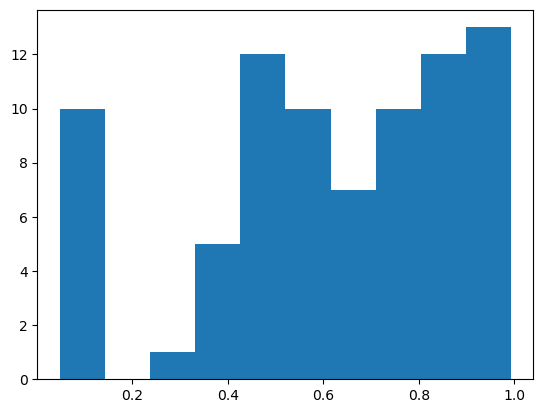

In [97]:
plt.hist(np.array([float(x) for x in annot_maf_df.loc[68878, 'alt_relative_positions'].strip('[').strip(']').split(',')]))

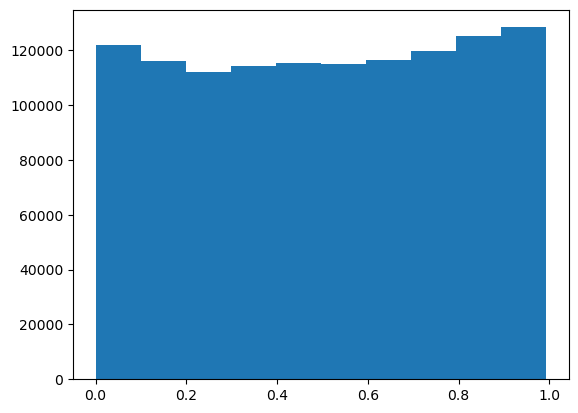

In [69]:
plt.hist(all_alt_relative_positions)
plt.ylabel('# reads')
plt.show()

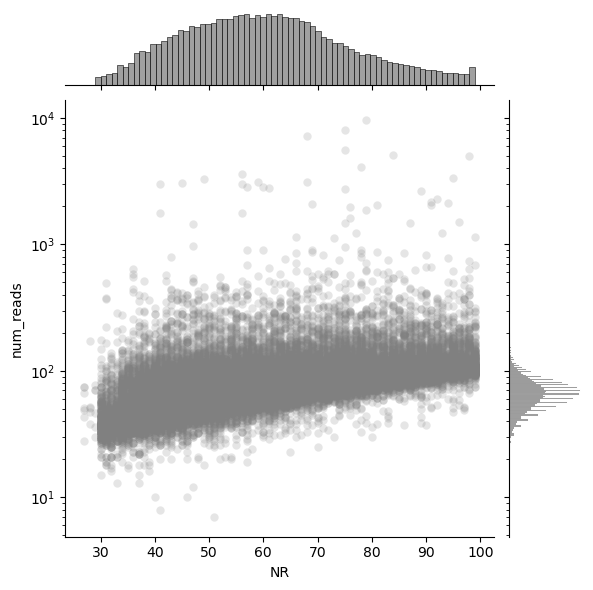

In [76]:
sns.jointplot(maf_df, x='NR', y='num_reads', linewidth=0, alpha=0.2, color='gray')
plt.yscale('log')
# plt.plot([0, 100], [0, 100], c='r')
plt.show()

In [41]:
maf_df.query("num_reads > 10000")

,Chr,Pos,Ref,Alt,NV,NR,VAF,nsegments,num_reads,num_alt_reads
6300,chr10,41846395,T,C,5,98,0.05102,NaN,15397.0,44.0


In [45]:
read.to_dict()

{'name': 'lh00125:292:22KHFFLT3:4:1189:25410:2506_GCTACTCACGTAATGC',
 'flag': '99',
 'ref_name': 'chr1',
 'ref_pos': '231933898',
 'map_quality': '60',
 'cigar': '9=1X140=',
 'next_ref_name': '=',
 'next_ref_pos': '231934040',
 'length': '292',
 'seq': 'CCTTGAGACTGGCACTACTTGGAAACATGACTGGCTATTTCTGCTGCAGGATTCCTGGTCCGGGCTCCAGCAAAATTATTGTTGTGAACATAGGCCTTGAAGAGGAGGCTGAAGCCGAGAAGCCAATATTCACTCACCTTTTCAACCTTC',
 'qual': 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
 'tags': ['NM:i:1',
  'AS:i:290',
  'nn:i:0',
  'tp:A:P',
  'cm:i:22',
  's1:i:254',
  's2:i:0',
  'de:f:0.0067',
  'rl:i:0',
  'CB:Z:GCTACTCACGTAATGC',
  'MQ:i:60',
  'MC:Z:110=1X39=',
  'ms:i:6000']}